# question
- deepcopy: 가중치와 구조를 완전히 독립적으로 복사하여 나중에 학습이 끝난 후 가장 성능이 좋았던 모델로 되돌리기 위해 사용
- valid_size_0.25: 일반적으로 60:20:20으로 분리하는 것을 권장하기 때문에
  - test는 0.2로 분리하고, train 데이터셋에서 valid를 0.25로 분리하면
  - 전체 데이터셋을 기준으로 60:20:20으로 분리됨
- batch_size: 전체 데이터셋을 한 번에 사용하여 가중치를 업데이트 함에 문제가 있어서 사용
  - 메모리 제한, 계산 효율성, 학습 안정성
  - 메모리: 너무 크면 GPU 메모리에 한 번에 올릴 수 없음
  - 계산 효율성: 전체 데이터를 한 번에 처리하면 오래걸릴 수 있음
  - 학습 안전성: 한 번에 업데이트 하는건 수렴이 느리고, 최적화 과정에서 지역 최적점에 빠지기 쉬움
  - 사용 크기
    - 소규모 배치: 1~32 (주로 16, 32)
    - 중간 규모 배치: 32~256 (주로 64 또는 128)
    - 대규모 배치: 256이상 (주로 256, 512, 1024 등)
  - 크기 줄일 때?:
    - OOM(out of memory) 에러가 발생하면 배치 크기 줄임

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy # 기억 잘 안남


from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 토치 관련
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 순서
  - 데이터 불러오기
  - 데이터셋 만들기
  - 데이터셋 tensor로 변환하기
  - 데이터셋 분리 후 섞기
  - 모델 정의하기
  - 학습 파라미터 정의하기
  - 학습시키기
  - val loss와 시각화해서 비교하기
  - 예측하기
  - 예측성능 보기
  - 혼동행렬, 보고서 출력

- 목표: 이진분류
  - 사용 손실함수 binary_cross_entropy
  - 활성화함수 relu
  - 예측활성화함수 sigmoid

In [12]:
# 1. 데이터 불러오기
cancer = load_breast_cancer()
print(cancer.keys())
print("\n\n")


# 2. 데이터셋 만들기
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

display(df.head())
print(cancer.target_names)
print("\n\n")


# 3. 데이터셋 텐서로 변환하기
tensor_data = torch.from_numpy(df.values).float()


# 4. 데이터 분리하기
X = tensor_data[:, :-1]
y = tensor_data[:, -1:]

print(X.shape, y.shape)
print("\n\n")


# 5. 학습, 평가, 검증 데이터 만들기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)
print("\n\n")


# 6. 모델 정의하기
# 6.1) model1
class DeepModel(nn.Module):
  def __init__(self, input_dim, output_dim):
    self.input_dim = input_dim
    self.output_dim = output_dim

    super().__init__()

    self.linear1 = nn.Linear(input_dim, 300)
    self.linear2 = nn.Linear(300, 100)
    self.linear3 = nn.Linear(100, 10)
    self.linear4 = nn.Linear(10, output_dim)

    self.act_relu = nn.ReLU()
    self.act_sigmoide = nn.Sigmoid()

  def forward(self, x):
    h = self.act_relu(linear1(x))
    h = self.act_relu(linear2(h))
    h = self.act_relu(linear3(h))
    y = self.act_sigmoid(linear4(h))

model1 = DeepModel(X.size(-1), y.size(-1))
print(model1)
print("\n\n")


# 6.2) model2
model2= nn.Sequential(
    nn.Linear(X_train.size(-1), 300),
    nn.ReLU(),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, y_train.size(-1)),
    nn.Sigmoid())
print(model2)
print("\n\n")

# 6.3) model3
class Total(nn.Module):
  def __init__(self,input_dim,output_dim):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(input_dim, 300),
        nn.ReLU(),
        nn.Linear(300, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
        nn.ReLU(),
        nn.Linear(10, output_dim),
        nn.Sigmoid())

  def forward(self, x):
    return self.model(x)

model3 = Total(X_train.size(-1), y_train.size(-1))
print(model3)
print("\n\n")


# 6. 학습 파라미터 정의하기
n_epochs = 1000        # 전체 학습 데이터를 몇 번 반복하여 학습할지 (에폭 수)
print_interval = 10      # 학습 진행 상황을 몇 에폭마다 출력할지
early_stop = 100     # Early Stopping을 위한 임계 에폭 (이 에폭 동안 손실이 개선되지 않으면 학습 중단)
batch_size = 64        # 한 번에 처리할 데이터 샘플의 개수 (배치 크기)
best_model = None       # 학습 중 가장 낮은 손실을 기록한 모델의 상태를 저장할 변수
criterion = nn.BCELoss()    # 이진 분류 문제에 사용되는 손실 함수 (Binary Cross Entropy Loss)
lowest_loss = np.inf     # 현재까지 기록된 가장 낮은 손실 값 (초기값은 무한대)
lowest_epoch = np.inf     # 가장 낮은 손실이 기록된 에폭 번호 (초기값은 무한대)
optimizer = optim.Adam(model3.parameters(), lr=0.001) # 모델의 가중치를 업데이트할 최적화 함수 (Adam 옵티마이저, 학습률 0.001)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])





,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


['malignant' 'benign']



torch.Size([569, 30]) torch.Size([569, 1])



torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([114, 30]) torch.Size([114, 1])
torch.Size([114, 30]) torch.Size([114, 1])



DeepModel(
  (linear1): Linear(in_features=30, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
  (linear4): Linear(in_features=10, out_features=1, bias=True)
  (act_relu): ReLU()
  (act_sigmoide): Sigmoid()
)



Sequential(
  (0): Linear(in_features=30, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
  (7): Sigmoid()
)



Total(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bia

In [13]:
# 7. 학습 시키기
train_loss_history, valid_loss_history = [], []

for i in range(n_epochs):
  model3.train()
  indices = torch.randperm(X_train.size(0))
  X_ = torch.index_select(X_train, dim=0, index = indices)
  y_ = torch.index_select(y_train, dim=0, index = indices)

  X_ = X_.split(batch_size, dim = 0)
  y_ = y_.split(batch_size, dim =0)

  train_loss, valid_loss = 0, 0

  for X_i , y_i in zip(X_, y_):
    pred_y_i = model3(X_i)
    loss = criterion(pred_y_i, y_i)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item() # 대안: float(loss)... --> gpu를 사용할 때 loss.item()이 더 권장

  train_loss = train_loss / len(X_)

  with torch.no_grad():
    X_ = X_valid.split(batch_size, dim=0)
    y_ = y_valid.split(batch_size, dim=0)

    for X_i, y_i in zip(X_, y_):
      pred_y_i = model3(X_i)
      loss = criterion(pred_y_i, y_i)

      valid_loss += loss.item()

    valid_loss = valid_loss / len(X_)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    if (i+1) % print_interval == 0:
      print(f"Epoch: {i+1}, train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, lowest_loss: {lowest_loss}")

    if valid_loss < lowest_loss:
      lowest_loss = valid_loss
      lowest_epoch = i

      best_model = deepcopy(model3)
    else:
      if early_stop > 0 and lowest_epoch + early_stop < i+1:
        print(f"{early_stop} epoch 동안 모델이 개선되지 않음 ")
        break

print(f"{lowest_epoch+1} epoch에서 가장 낮은 검증 손실값: {lowest_loss:.4f}")

# 8. 최고성능 모델 저장
model3.load_state_dict(best_model.state_dict())

Epoch: 10, train_loss: 0.2252, valid_loss: 0.2937, lowest_loss: 0.24918723106384277
Epoch: 20, train_loss: 0.2832, valid_loss: 0.3909, lowest_loss: 0.23511476814746857
Epoch: 30, train_loss: 0.2009, valid_loss: 0.2253, lowest_loss: 0.22950657457113266
Epoch: 40, train_loss: 0.2286, valid_loss: 0.2221, lowest_loss: 0.2240636721253395
Epoch: 50, train_loss: 0.1952, valid_loss: 0.2494, lowest_loss: 0.2174028605222702
Epoch: 60, train_loss: 0.1813, valid_loss: 0.2190, lowest_loss: 0.21418612450361252
Epoch: 70, train_loss: 0.2202, valid_loss: 0.2318, lowest_loss: 0.20566979050636292
Epoch: 80, train_loss: 0.2085, valid_loss: 0.2782, lowest_loss: 0.20535600185394287
Epoch: 90, train_loss: 0.2274, valid_loss: 0.2345, lowest_loss: 0.1993197500705719
Epoch: 100, train_loss: 0.1588, valid_loss: 0.2015, lowest_loss: 0.19800974428653717
Epoch: 110, train_loss: 0.2183, valid_loss: 0.1942, lowest_loss: 0.19052135944366455
Epoch: 120, train_loss: 0.1666, valid_loss: 0.1930, lowest_loss: 0.1901637241

<All keys matched successfully>

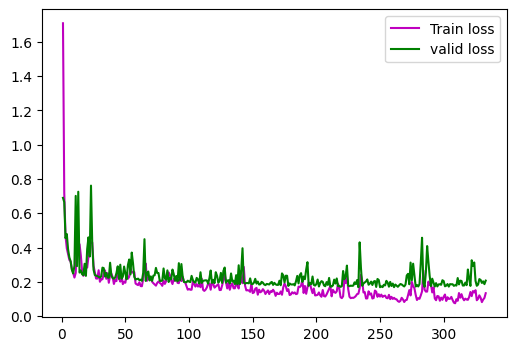




== 평가손실 및 비교 ==
train loss: 0.1313
vaild loss: 0.1689
test loss: 0.1040



다른방법
train loss: 0.1313
valid loss: 0.1689
test loss: 0.1040



== 정확도 ==
test 정확도: 0.9561



== 시각화 전 DF ==


,y_test,pred_y
0,1.0,6.458729e-01
1,0.0,1.226790e-11
2,0.0,2.369046e-05
3,1.0,9.969200e-01
4,1.0,9.978992e-01


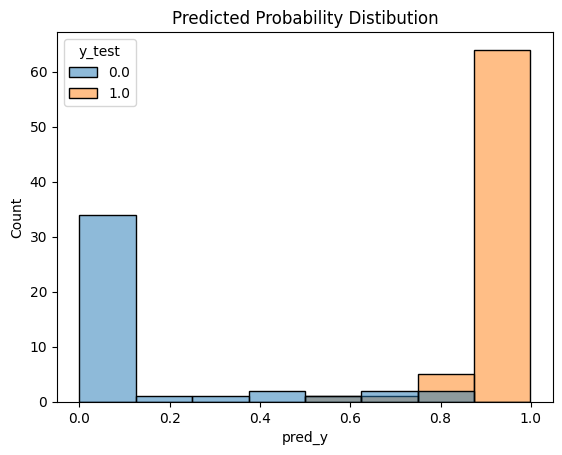




== 혼동행렬 ==


,pred 0.0,pred 1.0
True 0.0,38,5
True 1.0,0,71





== 분류 보고서 ==
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94        43
         1.0       0.93      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114






In [91]:
# 9. train, valid loss 곡선 시각화
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, label='Train loss', color='m')
plt.plot(range(1, len(valid_loss_history)+1), valid_loss_history, label='valid loss', color='g')
plt.legend()
plt.show()
print("\n\n")


# 10. 예측하기
test_loss = 0
pred_y = []

with torch.no_grad():
  X_ = X_test.split(batch_size, dim=0)
  y_ = y_test.split(batch_size, dim=0)

  for X_i, y_i in zip(X_, y_):
    pred_y_i = model3(X_i)
    loss = criterion(pred_y_i, y_i)

    test_loss += loss.item()
    pred_y.append(pred_y_i)

  test_loss = test_loss / len(X_)
  pred_y = torch.cat(pred_y, dim=0)

  # loss 출력
  print("== 평가손실 및 비교 ==")
  print(f"train loss: {train_loss_history[232]:.4f}")
  print(f"vaild loss: {valid_loss_history[232]:.4f}")
  print(f"test loss: {test_loss:.4f}")
  print("\n\n")


  # 다른 방법으로 확인하기
  history_info = list(zip(train_loss_history, valid_loss_history))
  sort_history = sorted(history_info, key=lambda x: x[1])
  print("다른방법")
  print(f"train loss: {sort_history[0][0]:.4f}")
  print(f"valid loss: {sort_history[0][1]:.4f}")
  print(f"test loss: {test_loss:.4f}")
  print("\n\n")


  # 정확도 계산
  acc = (y_test == (pred_y > 0.5)).sum() / len(y_test)
  print("== 정확도 ==")
  print(f"test 정확도: {acc:.4f}")
  print("\n\n")


  # 예측 결과 시각화하기
  df = pd.DataFrame(torch.cat([y_test, pred_y], dim=1).numpy(),
                  columns = ['y_test', 'pred_y'])
  print("== 시각화 전 DF ==")
  display(df.head())
  print("\n\n")

  plt.title("Predicted Probability Distibution")
  sns.histplot(df, x="pred_y", hue="y_test")
  plt.show()
  print("\n\n")


  print("== 혼동행렬 ==")
  change_bool = (pred_y > 0.5).float()
  display(pd.DataFrame(confusion_matrix(y_test, change_bool),
                       index = [f"True {y}" for y in y_test.unique()],
                       columns = [f"pred {y}" for y in change_bool.unique()]))
  print("\n\n")


  print("== 분류 보고서 ==")
  print(classification_report(y_test, change_bool))
  print("\n\n")

---
# 함수 설명

## randperm, index_select 설명
- randperm:
  - 지정한 수에 맞게 1차원 <font color=orange>무작위</font> 텐서 생성
- select_inndex:
  - 차원, 인덱스를 지정하면,
  - 차원을 기준으로 진행하며 연산을 수행하고
  - 지정한 인덱스를 <font color=orange>차례대로 뽑아옴</font>

In [5]:
num = torch.tensor([[1, 2, 3, 4],[5,6,7,8],[9,10,11,12]])
ind = torch.randperm(num.size(0))
shuffle = torch.index_select(num, 0, ind)
print(num)
print(num.size())
print(ind)
print(shuffle)

tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])
torch.Size([3, 4])
tensor([1, 2, 0])
tensor([[ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [ 1,  2,  3,  4]])


## split 설명
- 자를 사이즈, 기준 차원을 지정하면,
  - 차원을 기준으로 진행하며 지정한 사이즈에 맞게 잘라서 튜플로 반환함

In [6]:
cut = shuffle.split(split_size = 1, dim=0)
print(cut)
print(f"튜플 길이: {len(cut)}")
print(cut[0])
print(cut[0].size())

(tensor([[5, 6, 7, 8]]), tensor([[ 9, 10, 11, 12]]), tensor([[1, 2, 3, 4]]))
튜플 길이: 3
tensor([[5, 6, 7, 8]])
torch.Size([1, 4])


In [7]:
# model0 정의
model0 = nn.Sequential(
    nn.Linear(num.size(-1), 1))
print(model0)


# argument 'input' (position 1) must be Tensor, not tuple
# 즉, 현재 cut은 tuple상태라서 모델이 텐서가 아니므로 예측할 수 없어서 튜플에서 꺼내줘야 함
# model0(cut)


# cut에서 하나씩 꺼내서 텐서로 만든 후 예측
for t in (t.float() for t in cut):
  print(t)
  pred = model0(t)
  print(pred,"\n")

Sequential(
  (0): Linear(in_features=4, out_features=1, bias=True)
)
tensor([[5., 6., 7., 8.]])
tensor([[-5.7889]], grad_fn=<AddmmBackward0>) 

tensor([[ 9., 10., 11., 12.]])
tensor([[-8.8375]], grad_fn=<AddmmBackward0>) 

tensor([[1., 2., 3., 4.]])
tensor([[-2.7402]], grad_fn=<AddmmBackward0>) 



## item 설명
- torch의 `item()` 메서드는 <font color=orange>**단일 스칼라 값**</font>만 가진 텐서에서 해당 값을 파이썬 표준 숫자형으로 추출하여 반환
- 텐서가 하나 이상의 요소를 가지고 있으면 오류를 발생시킴
- <font color=orange>**텐서의 실제 값만 추출**</font>
  - 학습 시 `train_loss += loss.item()`과 같이 사용됩니다.
  - 여기서 `loss`는 계산된 손실 값 자체(숫자)와 함께,
  - 해당 텐서가 어떤 연산을 통해 생성되었는지에 대한 정보(`grad_fn` 등)를 담고 있음
  - 이 `grad_fn` 정보는 **실제 값에 해당하지 않으며,** `item()` 메서드 호출 시에는 추출되지 않고 무시됨 (오직 순수한 숫자 값만 반환)


In [8]:
a = torch.tensor([1])
a.item()

# a = torch.tensor([1, 2]) --> 오류 발생

1

## model.load_state_dict() 설명
- <font color=orange>dict로 파라미터, 텐서값 내보내고
- dict를 받아 model에 덮어씀</font>



---
*   **`model.state_dict()` 메서드:**
    *   PyTorch `nn.Module` (모델) 객체가 가지고 있는 <font color=orange>**모든 학습 가능한 파라미터(가중치와 편향)들을 Python 딕셔너리 형태로 반환**</font>
    *   이 딕셔너리의 키(key)는 각 레이어의 파라미터 이름이고, 값(value)은 해당 파라미터의 텐서
    *   모델의 '현재 상태'를 나타내는 일종의 '스냅샷'

*   **`model.load_state_dict(state_dict)` 메서드:**
    *   모델 객체에 <font color=orange>**주어진 `state_dict` 딕셔너리로부터 파라미터 값들을 로드(불러와서 적용)**</font>함
    *   딕셔너리의 키(파라미터 이름)와 현재 모델의 파라미터 이름이 일치해야 해당 값을 정확히 찾아 적용할 수 있음

---
*   **`model3.load_state_dict(best_model.state_dict())` 코드의 역할(정리):**
    *   model.state_dict(): 모델의 현재 상태(state), 즉 학습 가능한 모든 파라미터들(가중치와 편향)을 {'파라미터이름': 텐서값} 형태의 파이썬 딕셔너리로 "내보냄"

    * model.load_state_dict(some_dict): 인자로 받은 some_dict (바로 state_dict()로 생성된 것과 같은 형식의 딕셔너리)를 읽어서, 해당 딕셔너리 안에 있는 파라미터 이름과 값들을 현재 모델의 해당 파라미터 위치에 '붙여넣기' 또는 '로드(load)'
    * `즉, 모델의 가중치와 편향을 그 딕셔너리에 저장된 값으로 덮어쓰기`(overwrite)

In [9]:
#
#
#
#
#
#
#
#
#
#
#
#

---
# 학습 부분 주석 단 버전

In [11]:
# 트레인, 검증 손실 기록용 리스트 초기화
train_loss_history, valid_loss_history = [], []

# n_epochs 만큼 전체 데이터셋 반복 학습 시작
for i in range(n_epochs):
  # ------------ 1. 학습(Train) 단계 시작 ------------
  # 모델을 학습 모드로 전환. (Dropout, BatchNorm 같은 게 학습 시에만 작동하도록)
  model3.train()

  # 학습 데이터 매 에폭마다 섞기 (셔플링)
  # indices는 0부터 데이터 개수-1까지 숫자를 무작위로 섞은 1차원 텐서
  indices = torch.randperm(X_train.size(0))
  # index_select로 X_train이랑 y_train을 indices 순서대로 다시 뽑아서 섞음
  # dim=0은 행(샘플) 차원 기준
  X_ = torch.index_select(X_train, dim=0, index = indices)
  y_ = torch.index_select(y_train, dim=0, index = indices)

  # 섞은 데이터를 batch_size 크기로 잘라서 미니 배치 튜플로 만듦
  X_ = X_.split(batch_size, dim = 0)
  y_ = y_.split(batch_size, dim =0)

  # 현재 에폭의 총 학습 손실 초기화
  train_loss = 0
  # pred_y = [] # 이 리스트는 여기서 안 쓰거나 잘못 쓰일 수 있어서 필요 없음

  # 배치로 나뉜 학습 데이터를 하나씩 꺼내서 학습 시작
  for X_i , y_i in zip(X_, y_):
    # PyTorch에서 BCELoss는 타겟(y_i)이 float 타입이길 원함.
    # y_train이 정수형이면 여기서 y_i.float() 해줘야 함.

    # 1. 순전파: 현재 배치의 X_i를 모델에 넣고 예측값(pred_y_i) 얻기
    # model3는 nn.Sequential이라 model3(X_i)처럼 바로 호출 가능
    pred_y_i = model3(X_i)

    # 2. 손실 계산: 예측값(pred_y_i)이랑 실제 정답(y_i)을 criterion으로 비교해서 손실(loss) 계산
    loss = criterion(pred_y_i, y_i)

    # 3. 기울기 초기화: 이전 배치의 기울기 쌓인 거 0으로 초기화
    optimizer.zero_grad()

    # 4. 역전파: 계산된 loss를 가지고 모델 파라미터별로 기울기(gradient) 계산
    loss.backward()

    # 5. 가중치 업데이트: 옵티마이저가 계산된 기울기 써서 모델 파라미터들 업데이트
    optimizer.step()

    # 현재 배치의 손실을 에폭 총 학습 손실에 더하기. .item()은 텐서에서 숫자만 뽑음
    train_loss += loss.item()

  # 한 에폭의 평균 학습 손실 계산
  train_loss = train_loss / len(X_)
  # ------------ 학습(Train) 단계 끝 ------------


  # ------------ 2. 검증(Validation) 단계 시작 ------------
  # 모델을 평가 모드로 전환 (Dropout, BatchNorm 같은 거 꺼짐)
  model3.eval()

  # 검증할 때는 기울기 계산 필요 없으니 no_grad() 블록으로 감싸서 메모리랑 시간 아끼기
  with torch.no_grad():
    valid_loss = 0 # 현재 에폭의 총 검증 손실 초기화

    # 검증 데이터셋도 배치 크기로 나누기
    # X_와 y_ 변수명 재활용 대신 X_val_batches, y_val_batches처럼 해도 좋음
    X_val_batches = X_valid.split(batch_size, dim=0)
    y_val_batches = y_valid.split(batch_size, dim=0)

    # 검증 데이터 배치들 돌면서 모델 성능 평가
    for X_i, y_i in zip(X_val_batches, y_val_batches):
      # 순전파: 검증 데이터로 예측값 얻기
      pred_y_i = model3(X_i)

      # 손실 계산: 검증 데이터에 대한 손실 계산
      loss = criterion(pred_y_i, y_i)

      # 현재 배치의 검증 손실 누적
      valid_loss += loss.item()

    # 한 에폭의 평균 검증 손실 계산
    valid_loss = valid_loss / len(X_val_batches)
  # ------------ 검증(Validation) 단계 끝 ------------

  # 학습/검증 손실 기록 리스트에 추가
  train_loss_history.append(train_loss)
  valid_loss_history.append(valid_loss) # 오타 수정 (valid_lsos -> valid_loss)

  # print_interval 에폭마다 현재 상태 출력
  if (i+1) % print_interval == 0:
    print(f"Epoch: {i+1}, train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, lowest_loss: {lowest_loss:.4f}")

  # Early Stopping 로직: 검증 손실이 최저 손실보다 낮으면
  if valid_loss < lowest_loss:
    lowest_loss = valid_loss # 최저 손실 값 업데이트
    lowest_epoch = i         # 최저 손실이 나온 에폭 번호(0-base 인덱스) 업데이트

    # 가장 좋은 성능 냈던 모델 상태를 deepcopy로 저장 (나중에 이 모델 쓸 거임)
    best_model = deepcopy(model3)
  # 검증 손실이 개선 안 됐으면
  else:
    # earlystop_epoch이 0보다 크고, 최저 손실 이후 earlystop_epoch만큼 지나도 개선 없으면
    if early_stop > 0 and lowest_epoch + early_stop < i+1:
      print(f"{early_stop} epoch 동안 모델이 개선되지 않음 ")
      break # 학습 루프 중단

# 학습 다 끝났거나 Early Stopping으로 중단되면, 최종 결과 출력
print(f"{lowest_epoch+1} epoch에서 가장 낮은 검증 손실값: {lowest_loss:.4f}")

# 학습이 끝난 모델에 가장 좋았던 상태(가중치)를 다시 로드해서 적용
# 과적합 방지하고 가장 일반화 잘 되는 모델 쓸 거임
model3.load_state_dict(best_model.state_dict())

Epoch: 10, train_loss: 0.1811, valid_loss: 0.2141, lowest_loss: 0.1543
Epoch: 20, train_loss: 0.1709, valid_loss: 0.4117, lowest_loss: 0.1543
Epoch: 30, train_loss: 0.0953, valid_loss: 0.1719, lowest_loss: 0.1543
Epoch: 40, train_loss: 0.0985, valid_loss: 0.1962, lowest_loss: 0.1543
Epoch: 50, train_loss: 0.0963, valid_loss: 0.1650, lowest_loss: 0.1543
Epoch: 60, train_loss: 0.0997, valid_loss: 0.1731, lowest_loss: 0.1543
Epoch: 70, train_loss: 0.1664, valid_loss: 0.4003, lowest_loss: 0.1543
Epoch: 80, train_loss: 0.1234, valid_loss: 0.1825, lowest_loss: 0.1543
Epoch: 90, train_loss: 0.0935, valid_loss: 0.1847, lowest_loss: 0.1543
Epoch: 100, train_loss: 0.0725, valid_loss: 0.1782, lowest_loss: 0.1543
100 epoch 동안 모델이 개선되지 않음 
5 epoch에서 가장 낮은 검증 손실값: 0.1543


<All keys matched successfully>